# League of Legends Ranked Games Prediction
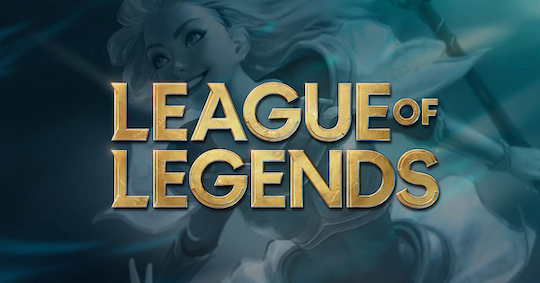

<br> 

`What is League of legend?`

League of Legends is an online MOBA (multiplayer online battle arena) where two teams(blue, red) of five champions face off to destroy the other's base. With hundreds of different champions available in game, players must work together with their teammates in order to defeat the other team.

<br>

5 players on each team join an arena that consits of 3 lanes(top, mid, bottom). The recommended formation among the lanes is a 1:1:2 distribution from top, mid, bottom with the remaining player taking on the jungle.

Each lane has minions that spawn and travel down the lane until meet the enemies minions in the middle.

<br>

Each team has 3 towers(turret) in each lane followed by an inhibitor which leads into your base. Inside your base is a Nexus guarded by 2 more towers. 

For a team to win they must destroy the other team's Nexus or make the other team surrender.

<br>

`Glossary`
>- Warding totem: An item that a player can put on the map to reveal the nearby area. Very useful for map/objectives control.
>- Minions: NPC that belong to both teams. They give gold when killed by players.
>- Jungle minions: NPC that belong to NO TEAM. They give gold and buffs when killed by players.
>- Elite monsters: Monsters with high hp/damage that give a massive bonus (gold/XP/stats) when killed by a team.
>- Dragons: Elite monster which gives team bonus when killed. The 4th dragon killed by a team gives a massive stats bonus. The 5th dragon (Elder Dragon) offers a huge advantage to the team.
>- Herald: Elite monster which gives stats bonus when killed by the player. It helps to push a lane and destroys structures.
>- Towers(Turret): Structures you have to destroy to reach the enemy Nexus. They give gold.
>- Level: Champion level. Start at 1. Max is 18.

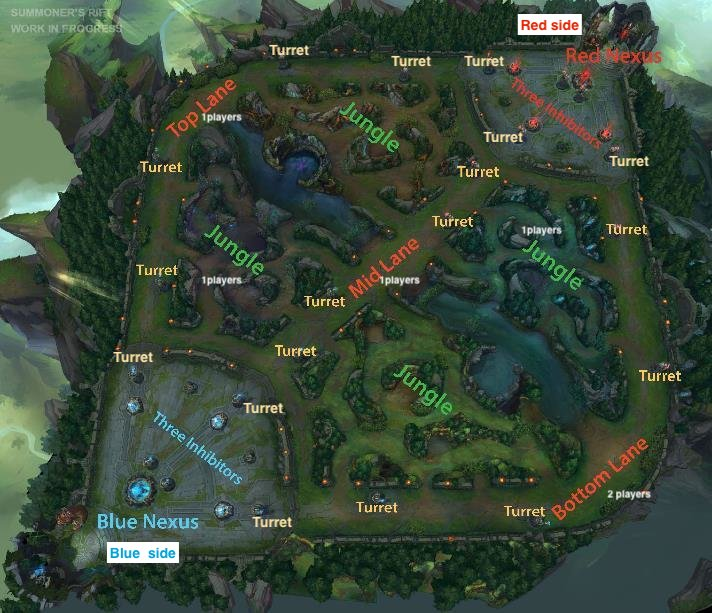

Fig. A map of the League of legends game play from: https://www.researchgate.net/figure/A-Map-of-the-League-of-Legends-game-play-in-the-classic-mode_fig1_319839481

---
Dataset: https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min

League of legends guide: https://www.leagueoflegends.com/en-us/how-to-play/

<br>

`Content`

This dataset contains the first 10min. 10k ranked games(solo queue) from a high mmr(diamond 1 to master).

Each game is unique and there is no missing value.

<br>

`Column`
>- gameId : Unique Riot ID of the game
>- blueWins : **target column** (1:blue team won, 0: red team won) 
>- xxWardsPlaced: Number of warding totems placed by xx(blue/red) team
>- xxWardsDestroyed: Number of enemy warding totems
>- xxFirstBlood: First kill of the game (1:blue team did, 0: red team did)
>- xxKills: Number of enemies killed
>- xxDeaths: Number of deaths
>- xxAssists: Number of kill assits
>- xxEliteMonsters: Number of elite monsters(Dragons and Heralds) killed
>- xxDragons: Number of dragons killed
>- xxHeralds: Number of heralds killed
>- xxTowersDestroyed: Number of structures destroyed
>- xxTotalGold: Total gold
>- xxAvgLevel: Average champion level
>- xxTotalExperience: Total experience
>- xxTotalMinionsKilled: Total minions killed (CS)
>- xxTotalJungleMinionsKilled: Total jungle monsters killed
>- xxGoldDiff: Gold difference compared to the enemy team
>- xxExperienceDiff: Experience difference compared to the enemy team
>- xxCSPerMin: CS per minute
>- xxGoldPerMin: Gold per minute

<br>

`The data collection method used was the following one`
>from: https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min/discussion/148164?sort=recent-comments
>1. Get hundreds of diamond player profiles on op.gg website
2. For each profile, try to get the last 10 ranked games (I get the ID attribute when parsing the HTML)
3. Deduplicate these game IDs
4. Call the Riot API for each game to get stats
5. Remove too short game (under 15min I believe)
6. Do some aggregations using game events
7. In unlikely cases, the games were two months old if the player is not very active. but in general, all games are from the season 10.

---

# 1. Importing libraries

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
#from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix

from statsmodels.stats.outliers_influence import variance_inflation_factor

#import eli5
#from eli5.sklearn import PermutationImportance 

#import optuna
#optuna.logging.set_verbosity(optuna.logging.WARNING) # silence trial results and parameters
from functools import partial
import os
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
pd.options.display.max_columns = 40 # display all columns

In [93]:
# Colour palette
palette = sns.blend_palette(['red', 'blue'], 2)

In [94]:
# Confusion matrix visualization
def plot_cm(cm):
    ax = sns.heatmap(cm, annot=True, fmt='g')
    ax.set_title('Confusion matrix')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values')
    plt.show()

In [95]:
# Using Variance Inflaction Factor(VIF, 다중공선성 파악)
def get_vif_df(df):
    df2 = df.copy()
    vif_df = pd.DataFrame()
    vif_df['VIF Factor'] = [variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])]
    vif_df['Features'] = df2.columns
    
    return vif_df.sort_values('VIF Factor', ascending=False)

# 2. Loading data

In [96]:
df = pd.read_csv('league_dataset.csv')

df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [98]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gameId,9879.0,4.500084e+09,2.757328e+07,4.295358e+09,4.483301e+09,4.510920e+09,4.521733e+09,4.527991e+09
blueWins,9879.0,4.990384e-01,5.000244e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
blueWardsPlaced,9879.0,2.228829e+01,1.801918e+01,5.000000e+00,1.400000e+01,1.600000e+01,2.000000e+01,2.500000e+02
blueWardsDestroyed,9879.0,2.824881e+00,2.174998e+00,0.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,2.700000e+01
blueFirstBlood,9879.0,5.048082e-01,5.000022e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
blueKills,9879.0,6.183925e+00,3.011028e+00,0.000000e+00,4.000000e+00,6.000000e+00,8.000000e+00,2.200000e+01
blueDeaths,9879.0,6.137666e+00,2.933818e+00,0.000000e+00,4.000000e+00,6.000000e+00,8.000000e+00,2.200000e+01
blueAssists,9879.0,6.645106e+00,4.064520e+00,0.000000e+00,4.000000e+00,6.000000e+00,9.000000e+00,2.900000e+01
blueEliteMonsters,9879.0,5.499544e-01,6.255265e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00
blueDragons,9879.0,3.619800e-01,4.805974e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [99]:
df.blueWins.value_counts()
# df.blueWins.value_counts(normalize=True)

blueWins
0    4949
1    4930
Name: count, dtype: int64

# 3. EDA

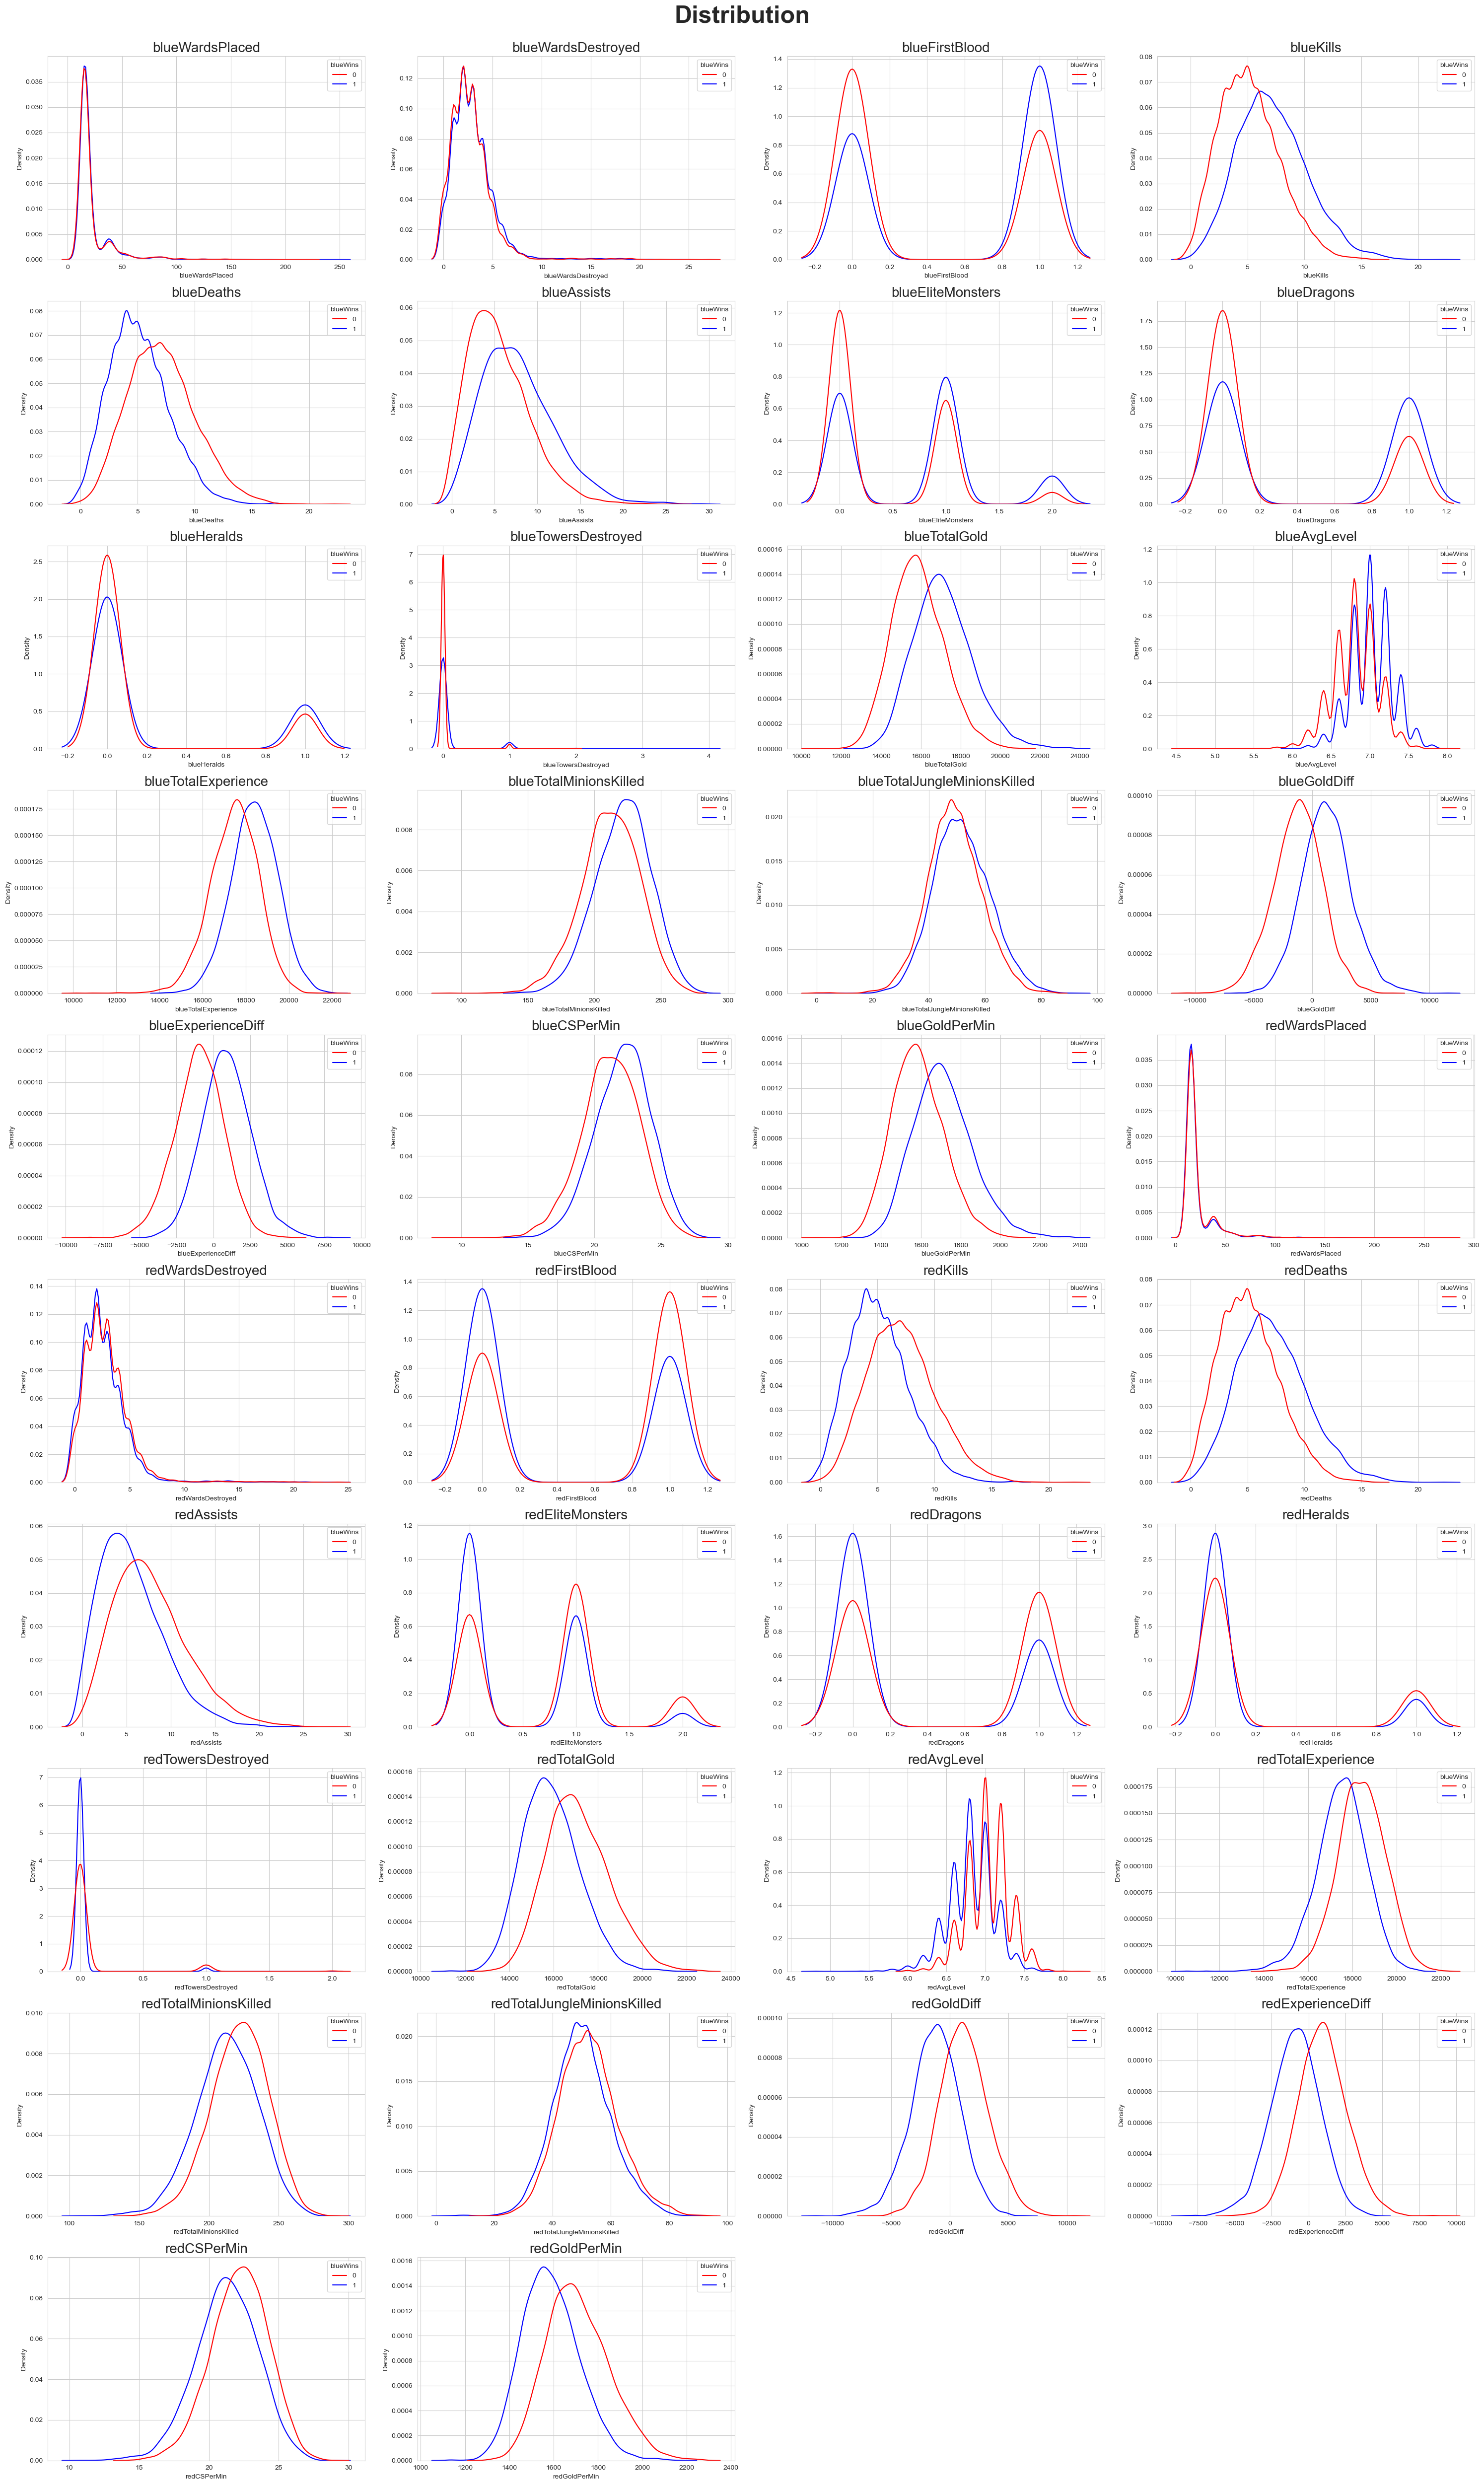

In [100]:
fig = plt.figure(figsize=(30, 50))
j = 1

for i in df.columns[2:]:
    plt.subplot(10, 4, j)
    sns.kdeplot(x=df[i], hue=df['blueWins'], palette=palette)
    plt.title(f'{i}', fontsize=20)
    j += 1
plt.suptitle('Distribution', fontsize=35, fontweight='bold', y=1)
plt.tight_layout()
plt.show()

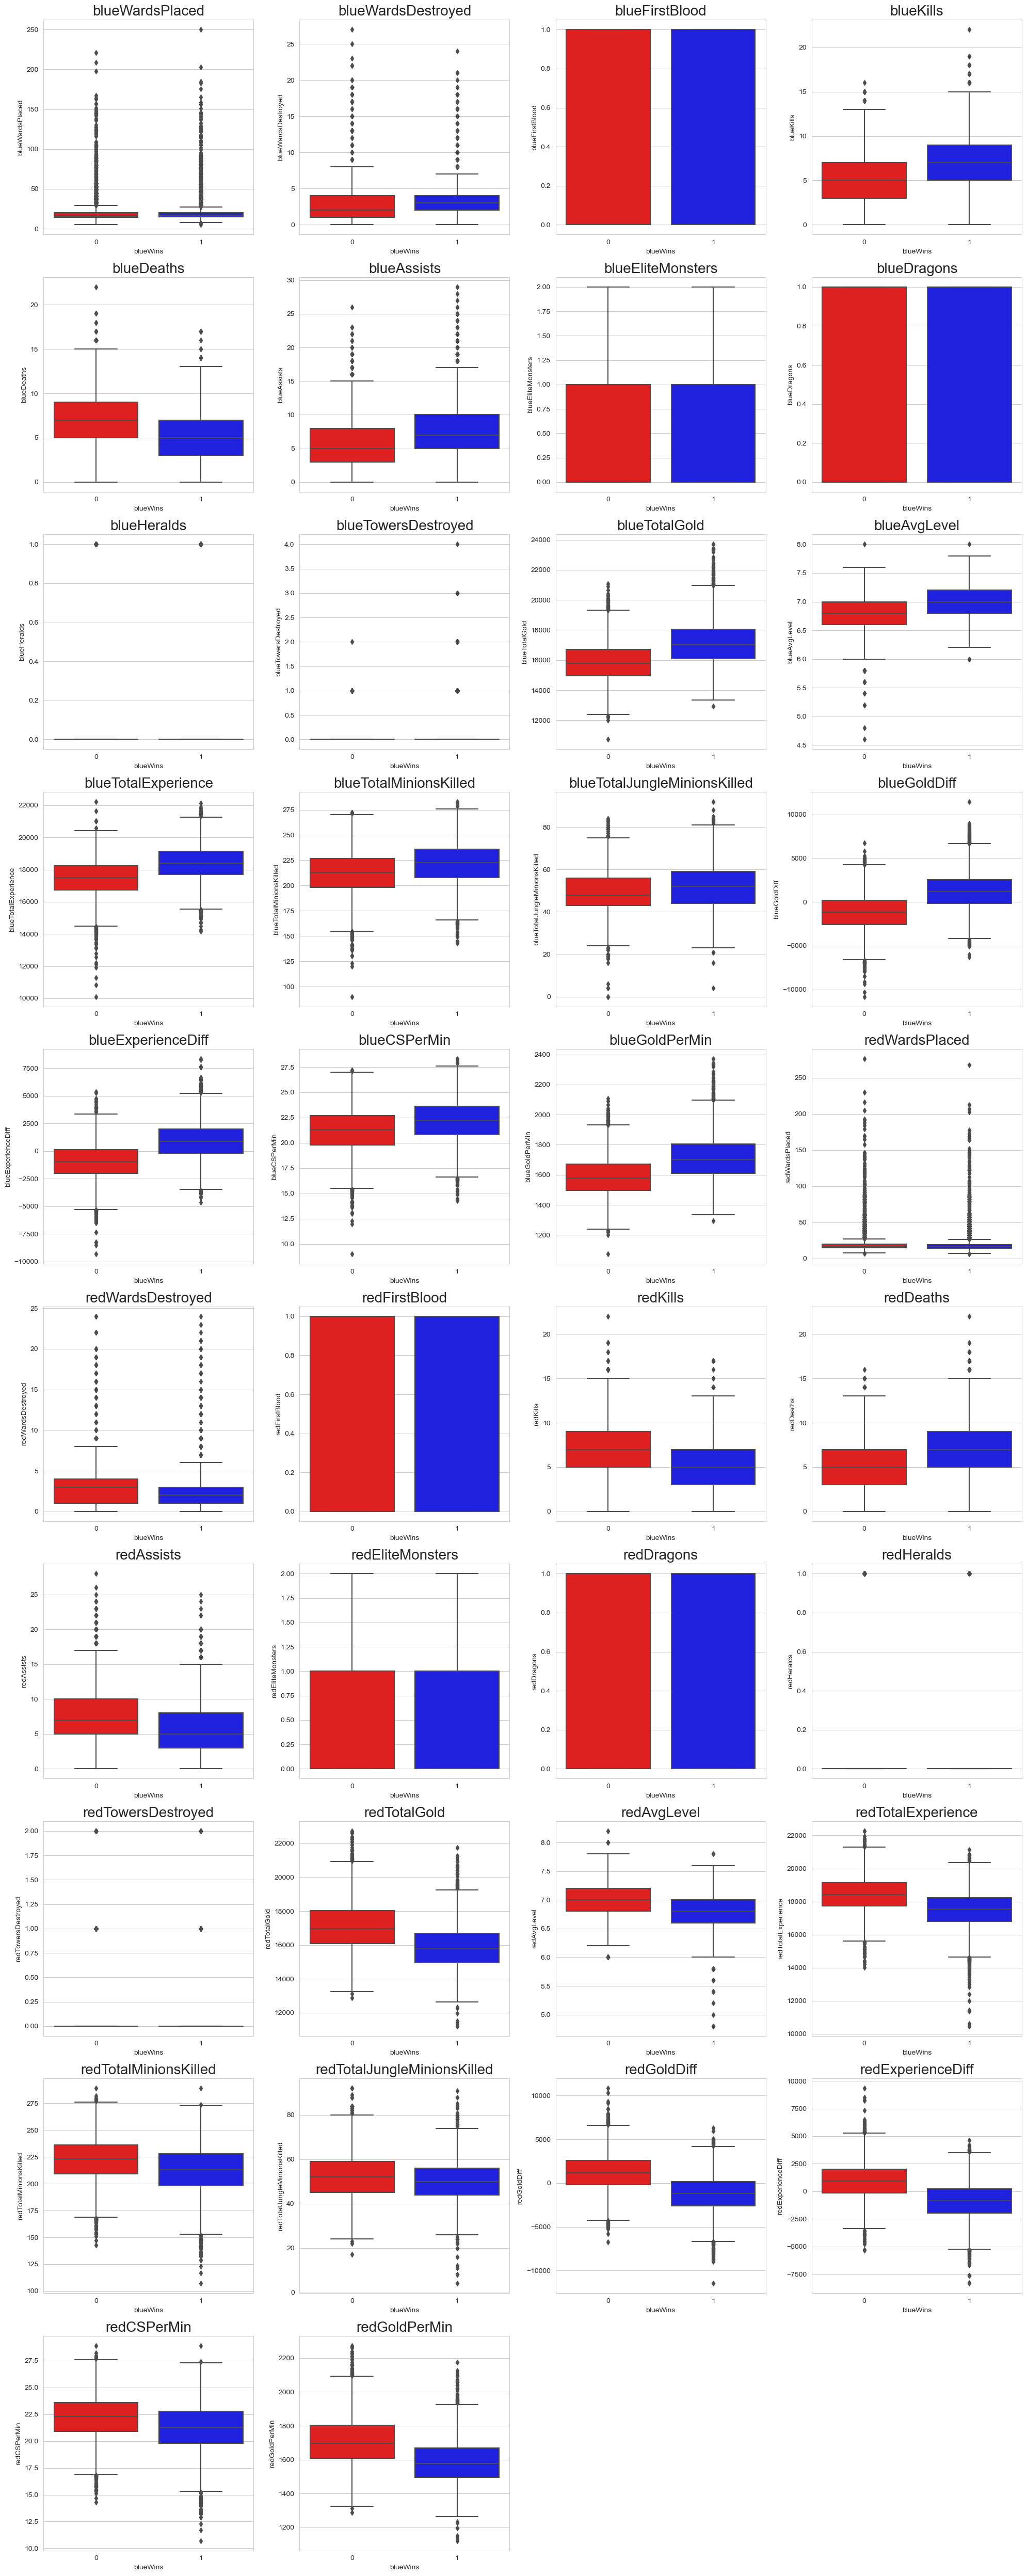

In [101]:
fig = plt.figure(figsize=(20, 50))
j = 1

for i in df.columns[2:]:
    plt.subplot(10, 4, j)
    sns.boxplot(x=df['blueWins'], y=df[i], palette=palette)
    plt.title(f'{i}', fontsize=20)
    j += 1
plt.tight_layout()
plt.show()

- Some outliers can be seen in 'xxWardsPlaced' and 'xxWardsDestroyed' features. (note)

In [102]:
print(df.groupby('blueWins').mean()['blueGoldDiff'])
print(df.groupby('blueWins').mean()['redGoldDiff'])

blueWins
0   -1237.066680
1    1270.718053
Name: blueGoldDiff, dtype: float64
blueWins
0    1237.066680
1   -1270.718053
Name: redGoldDiff, dtype: float64


In [103]:
print(df.groupby('blueWins').mean()['blueExperienceDiff'])
print(df.groupby('blueWins').mean()['redExperienceDiff'])

blueWins
0   -971.898969
1    908.274442
Name: blueExperienceDiff, dtype: float64
blueWins
0    971.898969
1   -908.274442
Name: redExperienceDiff, dtype: float64


- Gold and experience difference compared to the enemy team is the same.

In [104]:
print(df.groupby('blueWins').mean()['blueKills'])
print(df.groupby('blueWins').mean()['redDeaths'])
print('-'*30)
print(df.groupby('blueWins').mean()['blueDeaths'])
print(df.groupby('blueWins').mean()['redKills'])

blueWins
0    5.170135
1    7.201623
Name: blueKills, dtype: float64
blueWins
0    5.170135
1    7.201623
Name: redDeaths, dtype: float64
------------------------------
blueWins
0    7.131138
1    5.140365
Name: blueDeaths, dtype: float64
blueWins
0    7.131138
1    5.140365
Name: redKills, dtype: float64


- The number of enemies killed is the same as the number of deaths. There is no death by towers and minions.

In [105]:
pd.crosstab(index=df.blueTowersDestroyed, columns=df.blueWins, values=df.blueTowersDestroyed, aggfunc='count')

blueWins,0,1
blueTowersDestroyed,,
0,4835.0,4580.0
1,113.0,316.0
2,1.0,26.0
3,NaN,7.0
4,NaN,1.0


In [106]:
pd.crosstab(index=df.redTowersDestroyed, columns=df.blueWins, values=df.redTowersDestroyed, aggfunc='count')

blueWins,0,1
redTowersDestroyed,,
0,4647,4836
1,280,87
2,22,7


- There are more than three towers destroyed by the Blue Team only when the Blue Team wins.

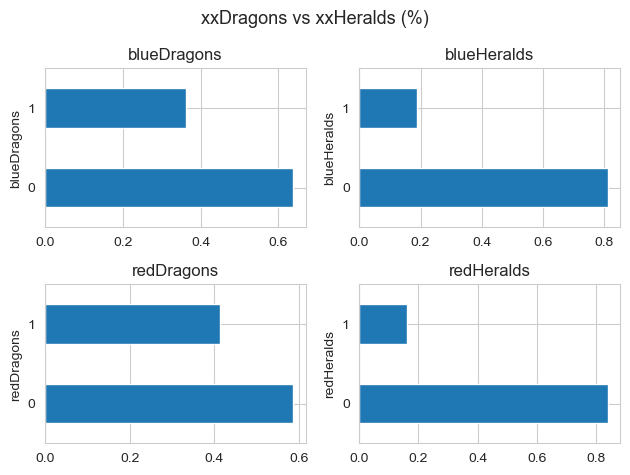

In [107]:
plt.subplot(2, 2, 1)
plt.title('blueDragons')
df.blueDragons.value_counts(normalize=True).plot(kind='barh')

plt.subplot(2, 2, 2)
plt.title('blueHeralds')
df.blueHeralds.value_counts(normalize=True).plot(kind='barh')

plt.subplot(2, 2, 3)
plt.title('redDragons')
df.redDragons.value_counts(normalize=True).plot(kind='barh')

plt.subplot(2, 2, 4)
plt.title('redHeralds')
df.redHeralds.value_counts(normalize=True).plot(kind='barh')

plt.suptitle('xxDragons vs xxHeralds (%)', fontsize=13)
plt.tight_layout()

- Both teams killed dragons more than heralds. Because the time that dragons spawn is shorter than the heralds.

|Elite monsters|Spawn time|Respawn time|
|------|---|---|
|Dragon|5 minutes|every 5 minutes after|
|Herald|8 minutes|6 minutes|

- Regular dragons will continue to spawn up until the elemental dragon soul is claimed by one team. ~~The elder dragon will spawn at 35 minutes or 6 minutes after the soul is taken.~~
- The rift herald spawns up to 2 times per game. The herald despawns permanently at 19:45 minutes and the Baron Nashor takes its place at 20 minutes.

<br> 

Source: https://www.esports.com/en/when-do-all-the-objectives-in-league-of-legends-spawn-277135

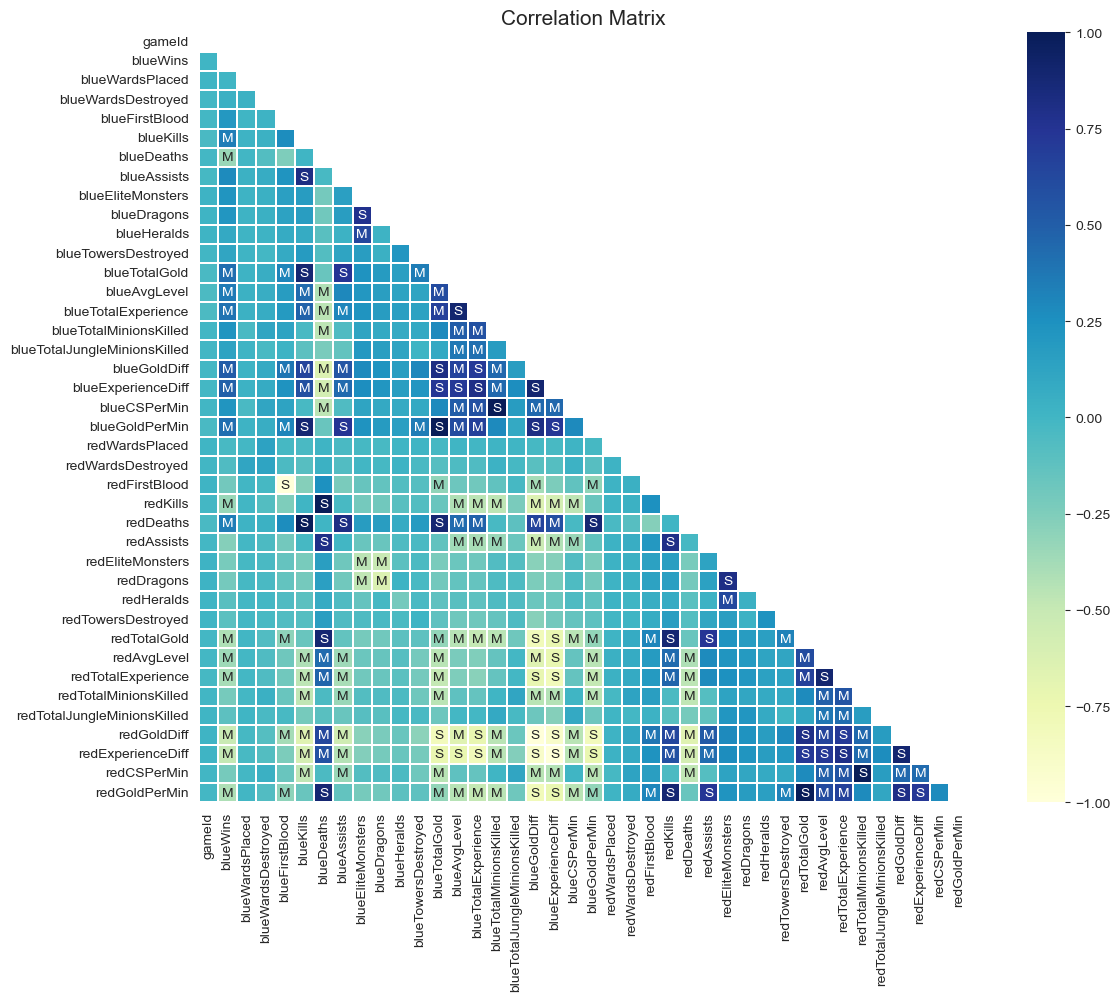

In [108]:
plt.figure(figsize=(15, 10))

labels = np.where(np.abs(df.corr())>=0.7,'S', np.where(np.abs(df.corr())>=0.3,'M', ''))

mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

g = sns.heatmap(data=df.corr(), square=True, linewidths=0.1, cmap='YlGnBu', mask=mask, annot=labels, fmt='')
g.set_xticklabels(g.get_xticklabels())
plt.title('Correlation Matrix', fontsize=15)
plt.show()

In [109]:
# corr(abs)
temp_corr = df.corr().abs()['blueWins'][1:]

temp_corr.sort_values(ascending=False)

blueWins                        1.000000
redGoldDiff                     0.511119
blueGoldDiff                    0.511119
redExperienceDiff               0.489558
blueExperienceDiff              0.489558
blueTotalGold                   0.417213
blueGoldPerMin                  0.417213
redTotalGold                    0.411396
redGoldPerMin                   0.411396
blueTotalExperience             0.396141
redTotalExperience              0.387588
blueAvgLevel                    0.357820
redAvgLevel                     0.352127
blueDeaths                      0.339297
redKills                        0.339297
blueKills                       0.337358
redDeaths                       0.337358
blueAssists                     0.276685
redAssists                      0.271047
blueCSPerMin                    0.224909
blueTotalMinionsKilled          0.224909
blueEliteMonsters               0.221944
redEliteMonsters                0.221551
blueDragons                     0.213768
redTotalMinionsK

- Can observe same correlation value.

# 4. Data Preprocessing

In [110]:
# Outlier detection using IQR rule
def get_outlier(df=None, column=None, weight=1.5):
    new_col = df[df['blueWins'] == 1][column] # Detect the outlier separately when the blueWins is 0 or 1
    quantile_25 = np.percentile(new_col.values, 25)
    quantile_75 = np.percentile(new_col.values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
  
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    outlier_idx = new_col[(new_col < lowest) | (new_col > highest)].index
    return outlier_idx

In [111]:
# Create dataframe after remove outlier by IQR rule
new_df = df.copy()

for col in new_df.columns[2:]:
    outlier_idx = get_outlier(df=new_df, column=col, weight=1.5)
    
    new_df.drop(outlier_idx, axis=0, inplace=True)

print('Removed outliers: %d' % (df.shape[0] - new_df.shape[0]))

Removed outliers: 3082


In [112]:
# Check
new_df

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,4527715781,0,12,2,0,4,5,5,2,1,1,0,15131,6.8,18216,214,61,-727,343,21.4,1513.1,17,4,1,5,4,2,0,0,0,0,15858,6.8,17873,248,48,727,-343,24.8,1585.8
9873,4527878058,1,18,2,1,12,6,13,0,0,0,0,18573,7.2,19391,207,46,2639,2364,20.7,1857.3,16,6,0,6,12,6,0,0,0,0,15934,6.6,17027,197,38,-2639,-2364,19.7,1593.4
9876,4527713716,0,23,1,0,6,7,5,0,0,0,0,15903,7.0,18032,210,45,-2416,-1877,21.0,1590.3,14,0,1,7,6,11,1,1,0,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,4527628313,0,14,4,1,2,3,3,1,1,0,0,14459,6.6,17229,224,48,-839,-1085,22.4,1445.9,66,4,0,3,2,1,0,0,0,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


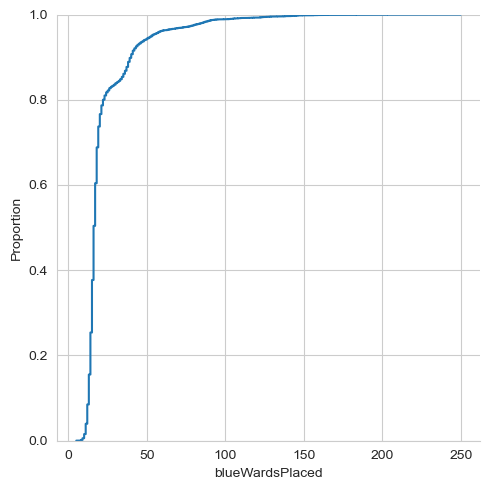

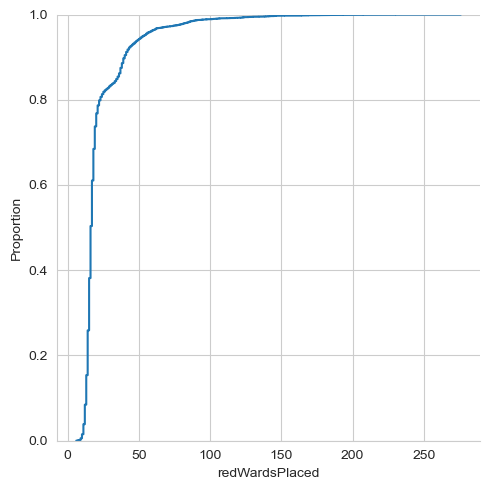

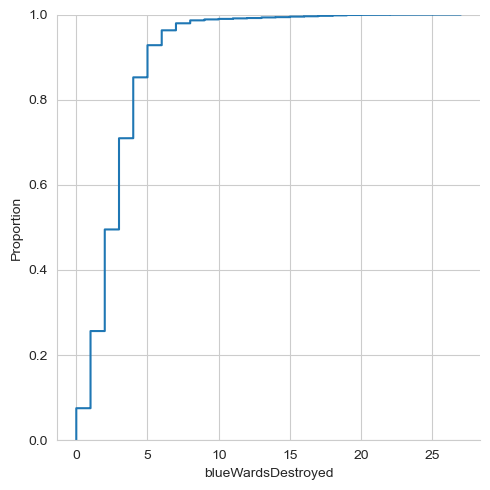

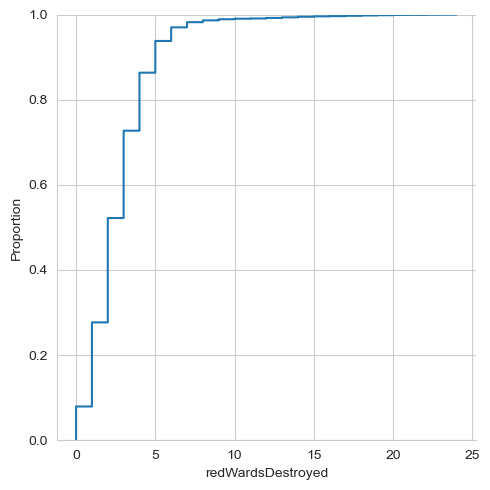

In [113]:
# ecdf plot of features with outliers
ecdf_col = ['blueWardsPlaced', 'redWardsPlaced', 'blueWardsDestroyed', 'redWardsDestroyed']

for col in ecdf_col:
    sns.displot(df[col], kind="ecdf")

In [114]:
# Remove outlier index
wardsplaced = ['blueWardsPlaced', 'redWardsPlaced']

for col in wardsplaced:
    outlier_idx = new_df[new_df[col] >= 100].index
    new_df.drop(outlier_idx, axis=0, inplace=True)

In [115]:
# Remove outlier index
wardsdestroyed = ['blueWardsDestroyed', 'redWardsDestroyed']

for col in wardsdestroyed:
    outlier_idx = new_df[new_df[col] >= 15].index
    new_df.drop(outlier_idx, axis=0, inplace=True)

In [116]:
# Check
new_df

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,4527715781,0,12,2,0,4,5,5,2,1,1,0,15131,6.8,18216,214,61,-727,343,21.4,1513.1,17,4,1,5,4,2,0,0,0,0,15858,6.8,17873,248,48,727,-343,24.8,1585.8
9873,4527878058,1,18,2,1,12,6,13,0,0,0,0,18573,7.2,19391,207,46,2639,2364,20.7,1857.3,16,6,0,6,12,6,0,0,0,0,15934,6.6,17027,197,38,-2639,-2364,19.7,1593.4
9876,4527713716,0,23,1,0,6,7,5,0,0,0,0,15903,7.0,18032,210,45,-2416,-1877,21.0,1590.3,14,0,1,7,6,11,1,1,0,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,4527628313,0,14,4,1,2,3,3,1,1,0,0,14459,6.6,17229,224,48,-839,-1085,22.4,1445.9,66,4,0,3,2,1,0,0,0,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


In [117]:
# Exclude features that exceed threshold
temp = new_df.corr()
temp_list = []

for x in temp.iterrows():
    idx, row = x[0], x[1] # index, series
    
    if idx in temp_list:
        continue
    
    candidate = row[row > 0.89].index[1:]
    
    if len(candidate) != 0:
        for col in candidate:
            temp_list.append(col)

print(f'Number of features: {len(temp_list)}\n {temp_list}')

Number of features: 7
 ['redDeaths', 'redKills', 'blueGoldPerMin', 'blueTotalExperience', 'blueCSPerMin', 'redGoldPerMin', 'redCSPerMin']


In [118]:
# To check for multicollinearity
temp = new_df.drop(temp_list, axis=1).drop(['gameId', 'blueWins'], axis=1)
temp

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,redWardsPlaced,redWardsDestroyed,redFirstBlood,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff
0,28,2,1,9,6,11,0,0,0,0,17210,6.6,195,36,643,-8,15,6,0,8,0,0,0,0,16567,6.8,17047,197,55,-643,8
1,12,1,0,5,5,5,0,0,0,0,14712,6.6,174,43,-2908,-1173,12,1,1,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173
2,15,0,0,7,11,4,1,1,0,0,16113,6.4,186,46,-1172,-1033,15,3,1,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033
3,43,1,0,4,5,5,1,0,1,0,15157,7.0,201,55,-1321,-7,15,2,1,10,0,0,0,0,16478,7.0,17961,235,47,1321,7
4,75,4,0,6,6,6,0,0,0,0,16400,7.0,210,57,-1004,230,17,2,1,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,12,2,0,4,5,5,2,1,1,0,15131,6.8,214,61,-727,343,17,4,1,2,0,0,0,0,15858,6.8,17873,248,48,727,-343
9873,18,2,1,12,6,13,0,0,0,0,18573,7.2,207,46,2639,2364,16,6,0,6,0,0,0,0,15934,6.6,17027,197,38,-2639,-2364
9876,23,1,0,6,7,5,0,0,0,0,15903,7.0,210,45,-2416,-1877,14,0,1,11,1,1,0,0,18319,7.4,19909,261,60,2416,1877
9877,14,4,1,2,3,3,1,1,0,0,14459,6.6,224,48,-839,-1085,66,4,0,1,0,0,0,0,15298,7.2,18314,247,40,839,1085


In [119]:
# get_vif_df(temp)

# Remove some of the variables have inf
get_vif_df(temp.drop(['redEliteMonsters', 'blueEliteMonsters', 'redGoldDiff', 'redTotalGold', 'redExperienceDiff'], axis=1))

,VIF Factor,Features
17,1466.960558,redFirstBlood
2,1215.502137,blueFirstBlood
13,39.869332,blueGoldDiff
9,31.937124,blueTotalGold
14,20.574486,blueExperienceDiff
23,14.305724,redTotalExperience
3,13.205011,blueKills
4,13.029640,blueDeaths
10,5.119816,blueAvgLevel
22,4.812723,redAvgLevel


In [120]:
# Remove features using VIF and permutation importance(Check 6. Standardization)
# X = new_df.drop(temp_list, axis=1).drop(['gameId', 'blueWins', 'redEliteMonsters', 'blueEliteMonsters', 'redGoldDiff', 
#                                          'redTotalGold', 'redExperienceDiff'], axis=1)
# y = new_df.blueWins

# Run the code after check permutation importance
X = new_df.drop(temp_list, axis=1).drop(['gameId', 'blueWins', 'redEliteMonsters', 'blueEliteMonsters', 'redGoldDiff', 
                                         'redTotalGold', 'redExperienceDiff', 'redAvgLevel', 'redTotalMinionsKilled', 'redFirstBlood'], axis=1)
y = new_df.blueWins

In [121]:
# Check
X

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,redWardsPlaced,redWardsDestroyed,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalExperience,redTotalJungleMinionsKilled
0,28,2,1,9,6,11,0,0,0,17210,6.6,195,36,643,-8,15,6,8,0,0,0,17047,55
1,12,1,0,5,5,5,0,0,0,14712,6.6,174,43,-2908,-1173,12,1,2,1,1,1,17438,52
2,15,0,0,7,11,4,1,0,0,16113,6.4,186,46,-1172,-1033,15,3,14,0,0,0,17254,28
3,43,1,0,4,5,5,0,1,0,15157,7.0,201,55,-1321,-7,15,2,10,0,0,0,17961,47
4,75,4,0,6,6,6,0,0,0,16400,7.0,210,57,-1004,230,17,2,7,1,0,0,18313,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9871,12,2,0,4,5,5,1,1,0,15131,6.8,214,61,-727,343,17,4,2,0,0,0,17873,48
9873,18,2,1,12,6,13,0,0,0,18573,7.2,207,46,2639,2364,16,6,6,0,0,0,17027,38
9876,23,1,0,6,7,5,0,0,0,15903,7.0,210,45,-2416,-1877,14,0,11,1,0,0,19909,60
9877,14,4,1,2,3,3,1,0,0,14459,6.6,224,48,-839,-1085,66,4,1,0,0,0,18314,40


# 5. Train-test split

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5630, 23) (994, 23) (5630,) (994,)


# 6. Standardization

In [123]:
categorical_columns = ['blueWins','blueFirstBlood', 'blueDragons', 'blueHeralds', 'redDragons' , 'redHeralds', 'blueTowersDestroyed', 'redTowersDestroyed']
columns_to_standarize = [col for col in X_train.columns.tolist() if col not in categorical_columns]
col_names = list(X_train.columns)
scaler = StandardScaler()

# X_train
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
# X_test
X_test_scaled = X_test.copy()
X_test_scaled[columns_to_standarize] = scaler.transform(X_test[columns_to_standarize])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

In [124]:
# Check
X_train_scaled

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,redWardsPlaced,redWardsDestroyed,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalExperience,redTotalJungleMinionsKilled
5830,-0.123240,-1.523209,0,-0.595745,1.174026,0.527404,0,1,0,-0.608633,-1.541735,0.007635,0.224235,-1.016192,-0.528179,-0.492027,1.969384,1.684801,1,0,0,0.221896,-0.783307
5264,-0.460015,-0.948240,0,-1.684486,-1.195551,-1.085170,0,0,0,-1.528342,-0.873171,-0.458064,1.464558,-0.512259,-0.601954,-0.492027,1.384130,-0.997041,1,0,0,0.496813,-0.380667
7228,-0.628403,-1.523209,1,0.492995,0.497004,-0.010120,1,0,0,0.626634,1.132522,0.752752,-0.189206,-0.720828,0.190010,-0.576906,-1.542138,1.440997,0,1,2,0.642358,1.028574
1417,-0.460015,-0.948240,0,-0.232832,-0.180018,-0.547645,0,0,0,-0.696814,1.132522,-0.877192,-0.706008,-0.436536,-0.387336,-0.661785,-0.956885,-0.021825,1,0,0,0.799582,1.934515
8891,2.234185,-0.373271,0,-0.958659,-0.180018,-1.622694,0,1,0,-0.850585,0.463957,0.939032,1.464558,-0.309888,-0.149802,-0.067632,0.213623,-0.997041,1,0,0,0.556109,0.625934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,-0.039046,0.201699,0,1.581735,1.174026,2.408740,0,0,0,1.875018,-0.204607,0.287054,-1.739610,0.535462,0.445429,1.714828,-0.371631,2.172409,1,1,0,-0.076381,-0.481327
9526,1.560635,-0.373271,1,0.130082,-0.518529,1.064929,0,1,0,0.338769,-0.873171,0.007635,0.637676,0.671852,1.391091,-0.407148,-1.542138,-0.021825,0,0,0,-2.459900,0.827254
6820,-0.291627,0.776668,0,0.855908,-1.534062,-0.010120,1,0,0,0.848180,1.132522,0.799322,-0.292567,2.059662,2.355198,-0.322269,1.969384,-1.484648,0,0,0,-2.704271,-0.682647
2721,-0.544209,-1.523209,1,-1.321572,-0.857040,-1.085170,0,0,0,-1.185820,-0.204607,-0.038935,0.017514,-0.330258,-0.756770,-0.492027,0.213623,-1.240845,0,0,0,1.204771,-0.280007


# 7. Training model

In [127]:
print(X_train_scaled.shape)

(5630, 23)


In [128]:
models = [['Logistic Regression', LogisticRegression(solver='liblinear', random_state=42)],
        ['Random Forest Classifier', RandomForestClassifier(random_state=42)]]

models_score = []

X_tr_scaled, X_val_scaled, y_tr, y_val = train_test_split(X_train_scaled, y_train, test_size=0.15, stratify=y_train, random_state=42)
print(X_tr_scaled.shape, X_val_scaled.shape, y_tr.shape, y_val.shape)

# training
for name, model in models:
    model = model
    model.fit(X_tr_scaled, y_tr)
    model_pred = model.predict(X_val_scaled)
    models_score.append(accuracy_score(y_val, model_pred))

    print(name)
    print('- Training   Accuracy: %.4f ' % accuracy_score(y_tr, model.predict(X_tr_scaled)))
    print('- Validation Acuuracy: %.4f \n' % accuracy_score(y_val, model_pred))
    print(classification_report(y_val, model_pred))
    
    # visualize roc curve
    fpr, tpr, thresholds = roc_curve(y_val, model_pred)

    fig = px.area(x=fpr, y=tpr, title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
                labels=dict(x='False Positive Rate', y='True Positive Rate'),
                width=600, height=400)
    fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()

    print('='*70)
    print('\n')

(4785, 23) (845, 23) (4785,) (845,)
Logistic Regression
- Training   Accuracy: 0.8347 
- Validation Acuuracy: 0.8438 

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       609
           1       0.74      0.67      0.71       236

    accuracy                           0.84       845
   macro avg       0.81      0.79      0.80       845
weighted avg       0.84      0.84      0.84       845





Random Forest Classifier
- Training   Accuracy: 1.0000 
- Validation Acuuracy: 0.8509 

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       609
           1       0.78      0.65      0.71       236

    accuracy                           0.85       845
   macro avg       0.83      0.79      0.80       845
weighted avg       0.85      0.85      0.85       845



In [129]:
# K-fold score, visualization
results=[]
names=[]

for name, model in models:
    kfold = StratifiedKFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %.4f (%.4f)' % (name, cv_results.mean(), cv_results.std()))

Logistic Regression: 0.8350 (0.0104)
Random Forest Classifier: 0.8355 (0.0075)


In [130]:
# Compare the accuracy of individual models and voting classifier
voting_models = [['Logistic Regression', LogisticRegression(solver='liblinear', random_state=42)],
                 ['Random Forest Classifier', RandomForestClassifier(random_state=42)]]

voting_clf = VotingClassifier(estimators=voting_models, voting='soft')
voting_clf.fit(X_train_scaled, y_train)
pred = voting_clf.predict(X_test_scaled)

print("Voting classifier accuracy: %.4f" % accuracy_score(y_test, pred))
print("Voting classifier roc_auc score: %.4f" % roc_auc_score(y_test, pred))

Voting classifier accuracy: 0.8451
Voting classifier roc_auc score: 0.7929


---

Accuracy: 0.8451 
Roc_auc score: 0.7985 

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       717
           1       0.74      0.69      0.71       277

    accuracy                           0.85       994
   macro avg       0.81      0.80      0.80       994
weighted avg       0.84      0.85      0.84       994



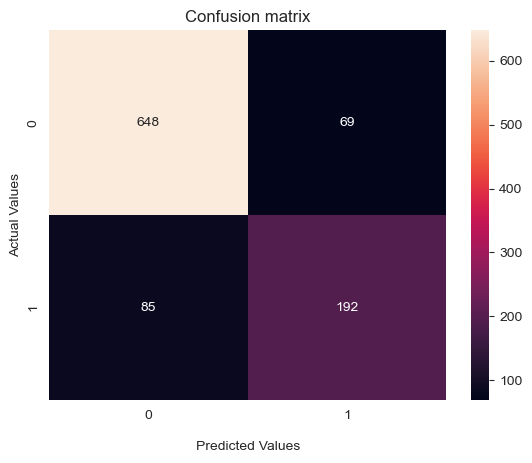

In [131]:
# final model training
final_model = LogisticRegression(solver='liblinear', random_state=42)
final_model.fit(X_train_scaled, y_train)
pred = final_model.predict(X_test_scaled)
cm_model = confusion_matrix(y_test, pred)

print("Accuracy: %.4f " % accuracy_score(y_test, pred))
print("Roc_auc score: %.4f \n" % roc_auc_score(y_test, pred))
print(classification_report(y_test, pred))
plot_cm(cm_model)

In [132]:
# Model feature importances visualization

`Conclusion`

This is the order of feature importance to give to the game in the first 10 minutes to have a ~85% chance of winning.
> Epic monsters, Gold, Experience, Warding, Tower Destroyed, Kills and Assists

If you found any mistakes or opinion on how to improve my notebook, please write in the comments :)

Thank you for the reading and wish you have a nice day!